In [1]:
from osgeo import osr, ogr, gdal
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
import numpy as np 
import pandas as pd 
import geopandas as gpd
import rasterio
from sklearn.model_selection import train_test_split
import geopandas as gpd
from rasterio.plot import show
from geohelpers import collocate, getCoords
from osgeo import osr, ogr, gdal
import pyproj
from pyproj import Proj, transform
import geopandas as gpd
import numpy as np
import rasterio
import pandas as pd
import seaborn as sns
import matplotlib as plt
from sklearn.model_selection import train_test_split
from sklearn import svm
import matplotlib.pyplot as plt
import math
import datetime
import geopandas as gpd
import warnings
from sklearn.preprocessing import QuantileTransformer
warnings. filterwarnings('ignore')

goal: produce a 30m raster where each pixel is binned by some index (using a dummy rn) Use SVR (support vector regression) for continuous multi-class classification.

In [2]:
td = r"FeatureMat\TDReal.shp"
scaler = QuantileTransformer(output_distribution='uniform')

td_gdf = gpd.read_file(td)

min_value = td_gdf['StlDEM_10m'].min()
max_value = td_gdf['StlDEM_10m'].max()
mean_values = td_gdf['StlDEM_10m'].mean()
std = td_gdf['StlDEM_10m'].std()
td_gdf['DEM'] = 1 - scaler.fit_transform(td_gdf['StlDEM_10m'].values.reshape(-1, 1)).reshape(-1)


td_gdf['Dist2Park'] = 1 - td_gdf['parksNormD']

columns_to_drop = ['OBJECTID', 'OBJECTID_1', 'StopName', 'StopAbbr', 'StopID','StlDEM_10m','parksNormD', 'BusCxn','City', 'StlPop_30m',
                  'NLNorm_fm','SBDs_bin_f','TIF_bin_fm','OppZones_b','Routes_bin','TDD_bin_fm','trans_weig','CID_bin_fm','parksNor_1','trans_we_1','TIF_bin__1']
td_gdf = td_gdf.drop(columns=columns_to_drop)
td_gdf = td_gdf.drop(columns='geometry')

In [3]:
td_df = pd.DataFrame(td_gdf)

In [4]:
import rasterio
import numpy as np

# List of raster file paths
raster_files = [
    r"FeatureMat\DEM.tif",
    r"FeatureMat\CID1.tif",
    r"FeatureMat\NLNorm.tif",
    r"FeatureMat\OppZones1.tif",
    r"FeatureMat\parksNormDist.tif",
    r"FeatureMat\StlPop.tif",
    r"FeatureMat\Routes1.tif",
    r"FeatureMat\SBDs.tif",
    r"FeatureMat\TDD.tif",
    r"FeatureMat\TransitWeigh1.tif",
    r"FeatureMat\RaceWeigh1.tif",
    r"FeatureMat\IncomeWeigh1.tif",
]

# Initialize an empty list to store the arrays
arrays = []

# Loop through each raster file and read it as an array
for file_path in raster_files:
    with rasterio.open(file_path,dtype = 'float32') as src:
        arr = src.read(1)  # Assuming you want to read the first band (index 0)
        if "StlPop" in file_path:
            arr[np.isnan(arr)] = 0
        arrays.append(arr)

# Concatenate the arrays along the third axis (axis=2) to create an nxmx10 array
feature_mat = np.stack(arrays, axis=2)


[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
Shape of the modified array: (320, 159, 12)
Data type of the modified array: float64
Mean value of the modified array: nan


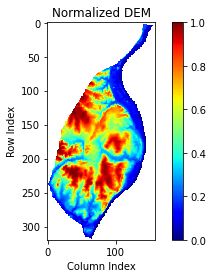

In [20]:
# Normalize and invert DEM and Parks bands 
dem = feature_mat[:, :, 0]
print(dem)
parks_norm_dist_band = feature_mat[:, :, 4]

from sklearn.preprocessing import QuantileTransformer

# Calculate mean and standard deviation excluding NaN values
mean_value = np.nanmean(dem)
std_value = np.nanstd(dem)
# Normalize the data to a 0-1 scale using QuantileTransformer
scaler = QuantileTransformer(output_distribution='uniform')
nd = 1-scaler.fit_transform(dem.reshape(-1, 1)).reshape(dem.shape)

min_parks_norm_dist = parks_norm_dist_band.min()
max_parks_norm_dist = parks_norm_dist_band.max()
normalized_parks_norm_dist = 1 - ((parks_norm_dist_band - min_parks_norm_dist) / (max_parks_norm_dist - min_parks_norm_dist))

feature_mat[:, :, 0] = nd
feature_mat[:, :, 4] = normalized_parks_norm_dist

#calculate index 

print("Shape of the modified array:", feature_mat.shape)
print("Data type of the modified array:", feature_mat.dtype)
print("Mean value of the modified array:", np.mean(feature_mat))

plt.imshow(nd, vmin=0, vmax=1, cmap = 'jet')  # Set vmin and vmax based on the normalized range (0 to 1)
plt.colorbar()  # Add colorbar to the plot
plt.title('Normalized DEM')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()

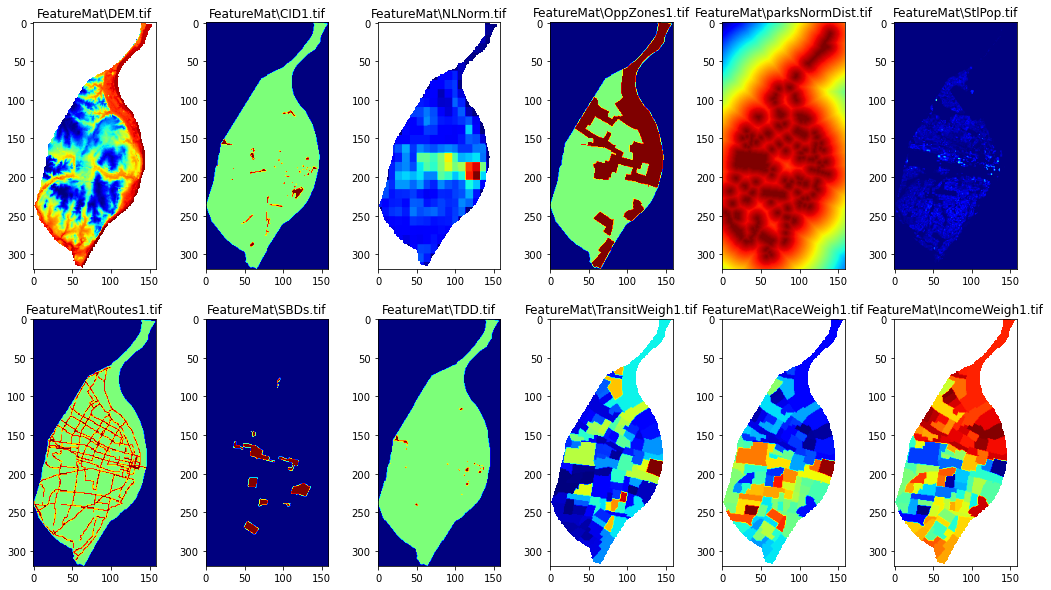

In [6]:
# Plot Classified Image 
fig, ax = plt.subplots(nrows=2, ncols=6, figsize=(18,10))
ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10, ax11 = ax.flatten()
axArr = ax.flatten()
ax_index = 0

for i in range(12):
    axArr[ax_index].imshow(feature_mat[:, :, i], cmap='jet')
    axArr[ax_index].set_title(raster_files[i])
    ax_index += 1

plt.show()

In [7]:
from sklearn import metrics
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import numpy as np

In [8]:
# calculate class labels (index)

# Extract the specified columns from td_df
selected_columns = ['IncomeWeig', 'RaceWeigh', 'TransitWei']

# Add the values of 'IncomeWeigh', 'RaceWeigh', and 'TransitWei' element-wise
sum_row = td_df[['IncomeWeig', 'RaceWeigh', 'TransitWei']].sum(axis=1)

# Append the sum row to td_df
td_df['Labels'] = sum_row.values

# Reset the index to ensure it's continuous
td_df.reset_index(drop=True, inplace=True)

td_df.head()

,id,Name,LON,LAT,StlPop_fm,CID_bin__1,OppZones_1,TransitWei,IncomeWeig,RaceWeigh,Routes_lin,TDD_lin_Cl,NLNorm_fm_,SBDs_bin_1,DEM,Dist2Park,Labels
0,1,Grand Blvd/Fairground Park,-90.217,38.661,0.057870,0,0,0.011515,0.009659,0.005883,1,0,0.146219,0,0.56,0.987548,0.027057
1,2,Palm St/Salisbury St,-90.209,38.658,0.001786,0,0,0.003169,0.009694,0.002066,1,0,0.146219,0,0.72,0.929010,0.014929
2,3,St Louis Ave,-90.211,38.653,0.000000,0,1,0.005282,0.009690,0.001918,1,0,0.177402,0,0.60,0.938364,0.016890
3,4,Cass Ave,-90.213,38.645,0.000000,0,1,0.005282,0.009690,0.001918,1,0,0.297629,0,0.36,0.948657,0.016890
4,5,Carr St,-90.213,38.640,0.000000,0,1,0.007817,0.009648,0.005992,1,0,0.297629,0,0.04,0.982390,0.023458


In [9]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)

In [10]:
# Assuming td_df is your DataFrame and 'StlPop_fm' is a column name
n_samples, n_features = td_df.shape[0], td_df.shape[1]-2
start = td_df.columns.get_loc('StlPop_fm')
print(start)
X = td_df.iloc[:, start:-1]
y = td_df.iloc[:,-1]  # Class labels
display(X)

4


,StlPop_fm,CID_bin__1,OppZones_1,TransitWei,IncomeWeig,RaceWeigh,Routes_lin,TDD_lin_Cl,NLNorm_fm_,SBDs_bin_1,DEM,Dist2Park
0,0.058,0,0,0.012,0.010,0.006,1,0,0.146,0,0.56,0.988
1,0.002,0,0,0.003,0.010,0.002,1,0,0.146,0,0.72,0.929
2,0.000,0,1,0.005,0.010,0.002,1,0,0.177,0,0.60,0.938
3,0.000,0,1,0.005,0.010,0.002,1,0,0.298,0,0.36,0.949
4,0.000,0,1,0.008,0.010,0.006,1,0,0.298,0,0.04,0.982
5,0.000,0,1,0.008,0.010,0.006,1,0,0.550,1,0.24,0.944
6,0.000,0,1,0.023,0.010,0.015,0,0,0.550,0,0.16,0.938
7,0.000,0,0,0.017,0.010,0.008,0,1,0.319,0,0.68,0.925
8,0.021,0,0,0.005,0.010,0.013,1,0,0.184,0,0.44,0.980
9,0.034,0,0,0.005,0.010,0.013,1,0,0.184,0,0.00,0.944


In [11]:
regr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
regr.fit(X, y)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svr', SVR(epsilon=0.2))])

In [12]:
m,n, h = feature_mat.shape
print('m: ',m,'n: ',n,'h: ',h)

m:  320 n:  159 h:  12


In [13]:
feature_mat_flat = feature_mat.reshape(m*n,h)
featdf = pd.DataFrame(feature_mat_flat)
#display(featdf)

In [14]:
import time
import numpy as np

start_time = time.time()  # Start timing

# Define batch size
batch_size = 100

print(feature_mat_flat.shape)
i = 0
assignments = []

for pix in feature_mat_flat:
    pix_no_nan = np.nan_to_num(pix, nan=0.0)  # Fill NaN values with zero
    pred = regr.predict(pix_no_nan.reshape(1, -1))
    assignments.append(pred)

    if i % 1000 == 0:
        #print(pix)
        print('pix:', i, 'prediction:', pred)
    
    i += 1
    
# End timing
end_time = time.time()
execution_time = end_time - start_time

(50880, 12)
pix: 0 prediction: [0.04295795]
pix: 1000 prediction: [0.04295795]
pix: 2000 prediction: [0.04295795]
pix: 3000 prediction: [0.04295795]
pix: 4000 prediction: [0.04295795]
pix: 5000 prediction: [0.04295795]
pix: 6000 prediction: [0.04295795]
pix: 7000 prediction: [0.04295795]
pix: 8000 prediction: [0.04295795]
pix: 9000 prediction: [0.04295795]
pix: 10000 prediction: [0.04295795]
pix: 11000 prediction: [0.04295795]
pix: 12000 prediction: [0.04295795]
pix: 13000 prediction: [0.04295795]
pix: 14000 prediction: [0.04295795]
pix: 15000 prediction: [0.04295795]
pix: 16000 prediction: [0.04295795]
pix: 17000 prediction: [0.04295795]
pix: 18000 prediction: [0.04295795]
pix: 19000 prediction: [0.04295795]
pix: 20000 prediction: [0.04295795]
pix: 21000 prediction: [0.04295795]
pix: 22000 prediction: [0.04295795]
pix: 23000 prediction: [0.04295795]
pix: 24000 prediction: [0.04295795]
pix: 25000 prediction: [0.04295795]
pix: 26000 prediction: [0.04295795]
pix: 27000 prediction: [0.042

In [15]:
print(f"Execution time: {execution_time} seconds")

Execution time: 24.41912078857422 seconds


In [16]:
assignmentsArr = np.array(assignments)
print(assignmentsArr.shape)
lc = assignmentsArr.reshape(m,n)
print(lc.shape)

(50880, 1)
(320, 159)


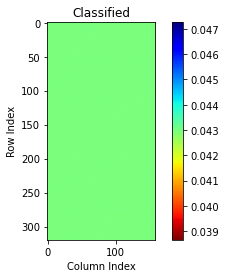

In [21]:
# Plot Classified Image 
img_class = plt.imshow(lc, cmap='jet_r')
plt.title('Classified')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.colorbar()

plt.show()

In [18]:
#function to write array to tiff
def write_geotiff(filename, arr, in_ds):
    if arr.dtype == np.float32:
        arr_type = gdal.GDT_Float32
    else:
        arr_type = gdal.GDT_Int32

    driver = gdal.GetDriverByName("GTiff")
    out_ds = driver.Create(filename, arr.shape[1], arr.shape[0], 1, arr_type)  # Create a 2D image
    out_ds.SetProjection(in_ds.GetProjection())
    out_ds.SetGeoTransform(in_ds.GetGeoTransform())
    out_ds.GetRasterBand(1).WriteArray(arr)  # Write the 2D image data to the GeoTIFF
    out_ds.FlushCache()
    out_ds = None  # Close the dataset to save changes

In [19]:
#function to 
write_geotiff("data\LandCoverStl.tif", lc, ndvi_ds)   


NameError: name 'ndvi_ds' is not defined